In [134]:
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook

# Inicializa el entorno AMPL con los módulos que necesitas y la licencia UUID
ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex"],  # Selección de módulos
    license_uuid="bb2c71f6-2b4c-4570-8eaf-4db0b0d7349a"  # Tu licencia UUID
)


Note: you may need to restart the kernel to use updated packages.
Licensed to Bundle #6733.7184 expiring 20241231: ICI5142-01 INVESTIGACION DE OPERACIONES AVANZADAS (Advanced Operations Research), Prof. Guillermo Cabrera-Guerrero, Pontificia Universidad Catolica de Valparaiso.


In [135]:
%%writefile cflp.mod
# Definición de conjuntos
set SR;  # Conjunto de regiones proveedoras
set DR;  # Conjunto de regiones demandantes

# Definición de parámetros
param fixcost{SR};    # Costo fijo para abrir una planta en cada región proveedora
param capacity{SR};   # Capacidad de las plantas en las regiones proveedoras
param demand{DR};     # Demanda en las regiones demandantes
param transp_cost{SR, DR};  # Costo de transporte entre regiones proveedoras y demandantes

# Variables de decisión
var Q{SR, DR} >= 0;  # Cantidad transportada de la región i a la región j
var y{SR} binary;    # Decisión de abrir o no la planta en la región i

# Función objetivo: minimizar el costo total
minimize Totalcost:
    sum{i in SR, j in DR} Q[i,j] * transp_cost[i,j] +
    sum{i in SR} y[i] * fixcost[i];

# Restricciones

# Satisfacer la demanda en todas las regiones demandantes
subject to Demand_Satisfaction{j in DR}:
    sum{i in SR} Q[i,j] == demand[j];

# No exceder la capacidad de las plantas abiertas
subject to Capacity_Limit{i in SR}:
    sum{j in DR} Q[i,j] <= capacity[i] * y[i];

Overwriting cflp.mod


In [136]:
%%writefile Mcflp.mod
# Definición de conjuntos
set SR;  # Conjunto de regiones proveedoras
set DR;  # Conjunto de regiones demandantes

# Definición de parámetros
param fixcost{SR};    # Costo fijo para abrir una planta en cada región proveedora
param capacity{SR};   # Capacidad de las plantas en las regiones proveedoras
param demand{DR};     # Demanda en las regiones demandantes
param transp_cost{SR, DR};  # Costo de transporte entre regiones proveedoras y demandantes

# Variables de decisión
var Q{SR, DR} >= 0;  # Cantidad transportada de la región proveedora i a la región demandante j
var y{SR} binary;    # Decisión de abrir o no la planta en la región i

# Función objetivo: minimizar el costo total
minimize Totalcost:
    sum{i in SR, j in DR} Q[i,j] * transp_cost[i,j] +
    sum{i in SR} y[i] * fixcost[i];

# Restricciones

# Satisfacer la demanda en todas las regiones demandantes
subject to Demand_Satisfaction{j in DR}:
    sum{i in SR} Q[i,j] >= demand[j];  # Se permite que una región demandante sea abastecida por varias plantas

# No exceder la capacidad de las plantas abiertas
subject to Capacity_Limit{i in SR}:
    sum{j in DR} Q[i,j] <= capacity[i] * y[i];

# Restringir las cantidades transportadas solo desde plantas abiertas
subject to Supply_Only_From_Open_Plants{i in SR, j in DR}:
    Q[i,j] <= capacity[i] * y[i];


Overwriting Mcflp.mod


In [137]:
%%writefile cflp.dat
# Conjuntos
set SR := 1 2 3;  # Regiones proveedoras
set DR := A B;    # Regiones demandantes

# Parámetros
param fixcost :=
    1 1000
    2 1500
    3 1200;

param capacity :=
    1 500
    2 700
    3 600;

param demand :=
    A 300
    B 400;

param transp_cost :  A  B :=
    1   4   6
    2   2   3
    3   5   8 ;


Overwriting cflp.dat


In [138]:
%%writefile Mcflp.dat
# Conjuntos
set SR := 1 2 3 4;  # Regiones proveedoras
set DR := A B C;    # Regiones demandantes

# Parámetros
param fixcost :=
    1 1200
    2 1600
    3 1300
    4 1800;

param capacity :=
    1 500
    2 800
    3 600
    4 700;

param demand :=
    A 350
    B 450
    C 300;

param transp_cost :  A  B  C :=
    1   4   6   5
    2   3   2   7
    3   6   5   4
    4   7   3   6 ;


Overwriting Mcflp.dat


In [139]:
%%ampl_eval
model cflp.mod;
data cflp.dat;
option solver gurobi;
solve;
display Q,y;

Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 3300
2 simplex iterations
1 branching node
Q :=
1 A     0
1 B     0
2 A   300
2 B   400
3 A     0
3 B     0
;

y [*] :=
1  0
2  1
3  0
;



In [140]:
%%ampl_eval
reset;
model Mcflp.mod;
data Mcflp.dat;
option solver gurobi;
solve;
display Q, y;


Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 6050
8 simplex iterations
1 branching node
Q :=
1 A     0
1 B     0
1 C     0
2 A   350
2 B   450
2 C     0
3 A     0
3 B     0
3 C   300
4 A     0
4 B     0
4 C     0
;

y [*] :=
1  0
2  1
3  1
4  0
;



Inicialización: Se crea una población inicial de individuos aleatorios.
Evaluación: Se evalúa cada individuo utilizando la función de aptitud.
Selección: Se seleccionan los individuos más aptos para reproducirse.
Cruce: Los individuos seleccionados se combinan para formar nuevos individuos.
Mutación: Se mutan algunos individuos aleatoriamente para garantizar la diversidad.
Reemplazo: Los individuos de la nueva generación reemplazan a la población anterior.

Repetición: Los pasos del 2 al 6 se repiten hasta que se cumpla la condición de parada.

In [141]:
import numpy as np

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion,demandas ,generaciones=100, tasa_mutacion=0.3):
    
    poblacion = np.random.randint(2, size=(10, num_instalaciones, num_clientes)) 

    def evaluacion(solucion): 
        
        costo_total = 0
        instalaciones_abiertas = np.zeros(num_instalaciones)

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    costo_total += costos_asignacion[instalacion][cliente]
                    instalaciones_abiertas[instalacion] += 1

       
        for i in range(num_instalaciones):
            if instalaciones_abiertas[i] > 0:
                costo_total += costos_apertura[i]

       
        for i in range(num_instalaciones):
            if instalaciones_abiertas[i] > capacidades[i]:
                return float('inf')  
            


        return costo_total

    def seleccion(poblacion):
       
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        indices = np.argsort(aptitudes)[:2] 
        return poblacion[indices]

    def cruce(padre1, padre2):
        
        punto_cruce = np.random.randint(1, num_clientes)
        hijo = np.zeros_like(padre1)
        for i in range(num_instalaciones):
            hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
            hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
        return hijo

    def mutacion(solucion):
      
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente] 
        return solucion

    def reemplazo(poblacion, hijo):
       
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        menos_aptos_index = np.argmin(aptitudes)
        poblacion[menos_aptos_index] = hijo

    def repeticion(poblacion):
        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            padres = seleccion(poblacion)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo)
            reemplazo(poblacion, hijo)
            mejor_costo = evaluacion(padres[0])
            print(f"Mejor costo: {mejor_costo}")

    print("Población inicial:")
    print(poblacion)

    repeticion(poblacion)


# Datos actualizados
num_instalaciones = 3  # Número de instalaciones
num_clientes = 2       # Número de clientes
capacidades = [500, 700, 600]  # Capacidades de las instalaciones
costos_apertura = [1000, 1500, 1200]  # Costos de apertura
costos_asignacion = np.random.randint(1, 50, size=(num_instalaciones, num_clientes))  # Costos de asignación aleatorios
demandas = [200, 300, 150]  # Demandas de los clientes

algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion,demandas)


Población inicial:
[[[1 1]
  [0 1]
  [0 0]]

 [[1 1]
  [1 1]
  [0 0]]

 [[0 1]
  [1 0]
  [1 1]]

 [[0 1]
  [1 0]
  [1 0]]

 [[1 1]
  [1 0]
  [0 0]]

 [[0 0]
  [0 1]
  [0 1]]

 [[1 0]
  [1 1]
  [1 1]]

 [[1 1]
  [1 0]
  [1 0]]

 [[1 1]
  [1 1]
  [0 0]]

 [[1 0]
  [0 1]
  [0 0]]]
Generación 1:
Mejor costo: 2553
Generación 2:
Mejor costo: 1013
Generación 3:
Mejor costo: 1013
Generación 4:
Mejor costo: 2564
Generación 5:
Mejor costo: 2566
Generación 6:
Mejor costo: 2566
Generación 7:
Mejor costo: 2566
Generación 8:
Mejor costo: 2566
Generación 9:
Mejor costo: 2553
Generación 10:
Mejor costo: 2599
Generación 11:
Mejor costo: 2608
Generación 12:
Mejor costo: 2608
Generación 13:
Mejor costo: 2608
Generación 14:
Mejor costo: 2608
Generación 15:
Mejor costo: 2608
Generación 16:
Mejor costo: 2608
Generación 17:
Mejor costo: 2608
Generación 18:
Mejor costo: 2595
Generación 19:
Mejor costo: 2599
Generación 20:
Mejor costo: 2599
Generación 21:
Mejor costo: 2564
Generación 22:
Mejor costo: 2608
Gene

In [142]:
import random
import math

# Definir los parámetros del problema (basado en el modelo AMPL)
SR = ['Proveedor1', 'Proveedor2', 'Proveedor3']  # Proveedores
DR = ['Cliente1', 'Cliente2', 'Cliente3']        # Demandantes

fixcost = {'Proveedor1': 1000, 'Proveedor2': 1500, 'Proveedor3': 2000}
capacity = {'Proveedor1': 500, 'Proveedor2': 600, 'Proveedor3': 400}
demand = {'Cliente1': 200, 'Cliente2': 300, 'Cliente3': 150}
transp_cost = {
    ('Proveedor1', 'Cliente1'): 2, ('Proveedor1', 'Cliente2'): 3, ('Proveedor1', 'Cliente3'): 1,
    ('Proveedor2', 'Cliente1'): 4, ('Proveedor2', 'Cliente2'): 1, ('Proveedor2', 'Cliente3'): 2,
    ('Proveedor3', 'Cliente1'): 5, ('Proveedor3', 'Cliente2'): 2, ('Proveedor3', 'Cliente3'): 3
}

# Generar una solución inicial aleatoria
def generar_solucion_inicial():
    Q = { (i, j): random.uniform(0, min(capacity[i], demand[j])) for i in SR for j in DR }
    y = { i: random.choice([0, 1]) for i in SR }
    return Q, y

# Calcular el costo total de una solución
def calcular_costo_total(Q, y):
    total_cost = 0
    for i in SR:
        total_cost += y[i] * fixcost[i]  # Costo fijo de abrir plantas
        for j in DR:
            total_cost += Q[i, j] * transp_cost[i, j]  # Costo de transporte
    return total_cost

# Generar una solución vecina
def generar_vecino(Q, y):
    vecino_Q = Q.copy()
    vecino_y = y.copy()

    # Modificar aleatoriamente la decisión de abrir o cerrar una planta
    planta_modificada = random.choice(list(SR))
    vecino_y[planta_modificada] = 1 - vecino_y[planta_modificada]

    # Modificar aleatoriamente el flujo entre una planta y un cliente
    proveedor_modificado, cliente_modificado = random.choice(list(Q.keys()))
    vecino_Q[proveedor_modificado, cliente_modificado] = random.uniform(0, capacity[proveedor_modificado])

    return vecino_Q, vecino_y

# Simulated Annealing
def simulated_annealing(temperatura_inicial, factor_enfriamiento, iteraciones_max):
    # Generar solución inicial
    solucion_actual_Q, solucion_actual_y = generar_solucion_inicial()
    costo_actual = calcular_costo_total(solucion_actual_Q, solucion_actual_y)

    # Definir solución óptima
    mejor_solucion_Q, mejor_solucion_y = solucion_actual_Q, solucion_actual_y
    mejor_costo = costo_actual

    temperatura = temperatura_inicial

    for _ in range(iteraciones_max):
        # Generar vecino
        vecino_Q, vecino_y = generar_vecino(solucion_actual_Q, solucion_actual_y)
        costo_vecino = calcular_costo_total(vecino_Q, vecino_y)

        # Si el vecino es mejor o si lo aceptamos por probabilidad
        if costo_vecino < costo_actual or random.uniform(0, 1) < math.exp((costo_actual - costo_vecino) / temperatura):
            solucion_actual_Q, solucion_actual_y = vecino_Q, vecino_y
            costo_actual = costo_vecino

            # Actualizar la mejor solución encontrada
            if costo_vecino < mejor_costo:
                mejor_solucion_Q, mejor_solucion_y = vecino_Q, vecino_y
                mejor_costo = costo_vecino

        # Reducir la temperatura
        temperatura *= factor_enfriamiento

    return mejor_solucion_Q, mejor_solucion_y, mejor_costo

# Parámetros de Simulated Annealing
temperatura_inicial = 10000
factor_enfriamiento = 0.99
iteraciones_max = 1000

# Ejecutar Simulated Annealing
mejor_Q, mejor_y, mejor_costo = simulated_annealing(temperatura_inicial, factor_enfriamiento, iteraciones_max)

print("Mejor asignación de transporte (Q):", mejor_Q)
print("Mejor decisión de apertura de plantas (y):", mejor_y)
print("Costo total mínimo:", mejor_costo)


Mejor asignación de transporte (Q): {('Proveedor1', 'Cliente1'): 67.3248401886285, ('Proveedor1', 'Cliente2'): 193.77151669346932, ('Proveedor1', 'Cliente3'): 252.0545842323496, ('Proveedor2', 'Cliente1'): 33.28700307808796, ('Proveedor2', 'Cliente2'): 333.8244751265477, ('Proveedor2', 'Cliente3'): 114.52602293140433, ('Proveedor3', 'Cliente1'): 31.546980189059994, ('Proveedor3', 'Cliente2'): 176.98897686601876, ('Proveedor3', 'Cliente3'): 90.82609928857921}
Mejor decisión de apertura de plantas (y): {'Proveedor1': 0, 'Proveedor2': 0, 'Proveedor3': 0}
Costo total mínimo: 2448.234500534798


In [50]:
import numpy as np

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100, tasa_mutacion=0.05):
    
    poblacion = np.random.randint(2, size=(50, num_instalaciones, num_clientes)) 

    def evaluacion(solucion): 
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)  # Capacidad usada en cada instalación
        demanda_satisfecha = np.zeros(num_clientes)  # Demanda satisfecha por cliente

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:  # No exceder demanda del cliente
                        costo_total += costos_asignacion[instalacion][cliente]
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]
        
        # Verificar capacidades de instalaciones
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:  # Penalizar si la capacidad de una instalación es excedida
                return float('inf')
        
        # Añadir costos de apertura de las instalaciones abiertas
        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]
        
        # Penalización si algún cliente no tiene su demanda completamente satisfecha
        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')
        
        return costo_total

    def seleccion(poblacion):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        indices = np.argsort(aptitudes)[:2]  # Seleccionar las 2 mejores soluciones
        return poblacion[indices]

    def cruce(padre1, padre2):
        punto_cruce = np.random.randint(1, num_clientes)
        hijo = np.zeros_like(padre1)
        for i in range(num_instalaciones):
            hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
            hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
        return hijo

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente] 
        return solucion

    def reemplazo(poblacion, hijo):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        menos_aptos_index = np.argmin(aptitudes)
        poblacion[menos_aptos_index] = hijo

    def repeticion(poblacion):
        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            padres = seleccion(poblacion)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo)
            reemplazo(poblacion, hijo)
            mejor_costo = evaluacion(padres[0])
            print(f"Mejor costo: {mejor_costo}")

    print("Población inicial:")
    print(poblacion)

    repeticion(poblacion)


# Datos actualizados
num_instalaciones = 3  # Número de instalaciones
num_clientes = 2       # Número de clientes
capacidades = [500, 700, 600]  # Capacidades de las instalaciones
costos_apertura = [1000, 1500, 1200]  # Costos de apertura

# Matriz de costos de asignación corregida a 3x2 (3 instalaciones y 2 clientes)
costos_asignacion = np.array([[4, 6],  # Instalación 1
                              [3, 2],  # Instalación 2
                              [6, 5]]) # Instalación 3

demandas = [300, 400]  # Demandas de los clientes

algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)


Población inicial:
[[[0 0]
  [1 0]
  [0 0]]

 [[0 1]
  [1 1]
  [0 1]]

 [[0 1]
  [0 1]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]

 [[0 0]
  [0 0]
  [0 0]]

 [[1 0]
  [0 1]
  [1 0]]

 [[1 0]
  [1 0]
  [1 1]]

 [[0 1]
  [1 1]
  [0 1]]

 [[0 1]
  [1 1]
  [0 0]]

 [[0 0]
  [1 0]
  [0 0]]

 [[0 0]
  [1 0]
  [1 1]]

 [[1 0]
  [1 1]
  [0 0]]

 [[1 0]
  [1 1]
  [1 0]]

 [[0 0]
  [1 0]
  [0 1]]

 [[1 1]
  [1 0]
  [0 0]]

 [[1 1]
  [1 1]
  [1 1]]

 [[0 0]
  [1 1]
  [0 0]]

 [[1 0]
  [0 1]
  [0 0]]

 [[1 0]
  [1 0]
  [1 1]]

 [[0 0]
  [0 0]
  [0 1]]

 [[1 1]
  [1 0]
  [1 0]]

 [[0 0]
  [0 1]
  [1 1]]

 [[1 1]
  [1 1]
  [0 1]]

 [[1 0]
  [0 1]
  [1 1]]

 [[0 0]
  [1 0]
  [0 0]]

 [[1 0]
  [1 1]
  [0 1]]

 [[1 0]
  [1 1]
  [0 1]]

 [[0 0]
  [0 1]
  [1 0]]

 [[0 1]
  [0 0]
  [0 1]]

 [[1 1]
  [0 1]
  [1 1]]

 [[1 0]
  [1 0]
  [1 1]]

 [[0 1]
  [1 1]
  [0 1]]

 [[0 1]
  [1 1]
  [0 1]]

 [[1 1]
  [1 1]
  [0 1]]

 [[1 1]
  [0 0]
  [0 1]]

 [[0 0]
  [1 1]
  [0 1]]

 [[0 1]
  [1 1]
  [0 0]]

 [[0 0]
  [1 1]
  [

In [95]:
import numpy as np

def simulated_annealing(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, temperatura_inicial=10000, tasa_enfriamiento=0.99, iteraciones=1000):

    # Generar una solución inicial aleatoria
    solucion_actual = np.random.randint(2, size=(num_instalaciones, num_clientes))

    def evaluacion(solucion):
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)  # Capacidad usada en cada instalación
        demanda_satisfecha = np.zeros(num_clientes)  # Demanda satisfecha por cliente

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:  # No exceder demanda del cliente
                        costo_total += costos_asignacion[instalacion][cliente]
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]

        # Verificar capacidades de instalaciones
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:  # Penalizar si la capacidad de una instalación es excedida
                return float('inf')

        # Añadir costos de apertura de las instalaciones abiertas
        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]

        # Penalización si algún cliente no tiene su demanda completamente satisfecha
        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')

        return costo_total

    def mutacion(solucion):
        # Generar una nueva solución con pequeños cambios aleatorios
        nueva_solucion = np.copy(solucion)
        instalacion = np.random.randint(num_instalaciones)
        cliente = np.random.randint(num_clientes)
        nueva_solucion[instalacion][cliente] = 1 - nueva_solucion[instalacion][cliente]
        return nueva_solucion

    def probabilidad_aceptacion(costo_actual, nuevo_costo, temperatura):
        if nuevo_costo < costo_actual:
            return 1.0
        else:
            return np.exp(-(nuevo_costo - costo_actual) / temperatura)

    # Inicialización
    temperatura = temperatura_inicial
    solucion_mejor = solucion_actual
    costo_mejor = evaluacion(solucion_actual)

    for i in range(iteraciones):
        # Crear una nueva solución basada en una mutación
        nueva_solucion = mutacion(solucion_actual)
        costo_actual = evaluacion(solucion_actual)
        nuevo_costo = evaluacion(nueva_solucion)

        # Decidir si se acepta la nueva solución
        if probabilidad_aceptacion(costo_actual, nuevo_costo, temperatura) > np.random.random():
            solucion_actual = nueva_solucion

        # Actualizar la mejor solución encontrada
        if nuevo_costo < costo_mejor:
            solucion_mejor = nueva_solucion
            costo_mejor = nuevo_costo

        # Enfriar el sistema
        temperatura *= tasa_enfriamiento

        print(f"Iteración {i + 1}: Mejor costo = {costo_mejor}")

    print("Mejor solución encontrada:")
    print(solucion_mejor)

# Datos actualizados
num_instalaciones = 3  # Número de instalaciones
num_clientes = 2       # Número de clientes
capacidades = [500, 700, 600]  # Capacidades de las instalaciones
costos_apertura = [1000, 1500, 1200]  # Costos de apertura

# Matriz de costos de asignación corregida a 3x2 (3 instalaciones y 2 clientes)
costos_asignacion = np.array([[4, 6],  # Instalación 1
                              [3, 2],  # Instalación 2
                              [6, 5]]) # Instalación 3

demandas = [300, 400]  # Demandas de los clientes

simulated_annealing(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)


Iteración 1: Mejor costo = 2506
Iteración 2: Mejor costo = 2209
Iteración 3: Mejor costo = 2209
Iteración 4: Mejor costo = 2209
Iteración 5: Mejor costo = 2209
Iteración 6: Mejor costo = 2209
Iteración 7: Mejor costo = 2209
Iteración 8: Mejor costo = 2209
Iteración 9: Mejor costo = 2209
Iteración 10: Mejor costo = 2209
Iteración 11: Mejor costo = 2209
Iteración 12: Mejor costo = 2209
Iteración 13: Mejor costo = 2209
Iteración 14: Mejor costo = 2209
Iteración 15: Mejor costo = 2209
Iteración 16: Mejor costo = 2209
Iteración 17: Mejor costo = 2209
Iteración 18: Mejor costo = 2209
Iteración 19: Mejor costo = 2209
Iteración 20: Mejor costo = 2209
Iteración 21: Mejor costo = 2209
Iteración 22: Mejor costo = 2209
Iteración 23: Mejor costo = 2209
Iteración 24: Mejor costo = 2209
Iteración 25: Mejor costo = 2209
Iteración 26: Mejor costo = 2209
Iteración 27: Mejor costo = 1505
Iteración 28: Mejor costo = 1505
Iteración 29: Mejor costo = 1505
Iteración 30: Mejor costo = 1505
Iteración 31: Mejor

In [36]:
import numpy as np

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, max_iter=100):
    estado_inicial = (
        np.random.randint(0, 2, num_instalaciones),  # Estado binario: instalaciones abiertas/cerradas
        np.random.randint(0, num_instalaciones, num_clientes)  # Asignación inicial de clientes a instalaciones
    )
    
    def evaluate(state):
        """
        Función de evaluación del costo total para el CFLP.
        - `state[0]`: Matriz binaria que indica qué instalaciones están abiertas.
        - `state[1]`: Vector que indica la asignación de cada cliente a una instalación.
        """
        facility_open = state[0]
        customer_assignment = state[1]

        # Costo de abrir instalaciones
        open_cost = np.sum(facility_open * costos_apertura)
        
        # Costo de asignación de clientes
        assignment_cost = 0
        facility_load = np.zeros(num_instalaciones)  # Carga en cada instalación
        
        for i, assigned_facility in enumerate(customer_assignment):
            if facility_open[assigned_facility] == 0:
                return float('inf')  # Penalización si el cliente está asignado a una instalación cerrada
            assignment_cost += costos_asignacion[assigned_facility][i]
            facility_load[assigned_facility] += demandas[i]
        
        # Penalización si alguna instalación excede su capacidad
        if np.any(facility_load > capacidades):
            return float('inf')

        return open_cost + assignment_cost  # Retornamos el costo total

    def generar_poblacion(state):
        new_facility_open = state[0].copy()
        new_customer_assignment = state[1].copy()

        if np.random.rand() < 0.5:
            i = np.random.randint(num_instalaciones)
            new_facility_open[i] = 1 - new_facility_open[i]
        else:
            i = np.random.randint(num_clientes)
            open_facilities = np.where(new_facility_open == 1)[0]
            if len(open_facilities) > 0:
                new_customer_assignment[i] = np.random.choice(open_facilities)

        return (new_facility_open, new_customer_assignment)

    def seleccion(state):
        nueva_matriz = generar_poblacion(state)
        if evaluate(nueva_matriz) < evaluate(state):
            state = nueva_matriz
        return state

    def crossover(state):
        facility_open = state[0]
        customer_assignment = state[1]
        punto_de_corte = np.random.randint(1, num_instalaciones)
        hijo1_facilities = np.concatenate((facility_open[:punto_de_corte], facility_open[punto_de_corte:]))
        hijo2_facilities = np.concatenate((facility_open[punto_de_corte:], facility_open[:punto_de_corte]))
        hijo1_assignment = np.concatenate((customer_assignment[:punto_de_corte], customer_assignment[punto_de_corte:]))
        hijo2_assignment = np.concatenate((customer_assignment[punto_de_corte:], customer_assignment[:punto_de_corte]))
        return (hijo1_facilities, hijo1_assignment), (hijo2_facilities, hijo2_assignment)

    def mutacion(hijo1, hijo2):
        probabilidad_mutacion = 0.20
        if np.random.rand() < probabilidad_mutacion:
            hijo1 = generar_poblacion(hijo1)
        if np.random.rand() < probabilidad_mutacion:
            hijo2 = generar_poblacion(hijo2)
        return hijo1, hijo2

    state = estado_inicial

    for _ in range(max_iter):
        if evaluate(state) == 0:
            return state
        state = seleccion(state)
        hijo1, hijo2 = crossover(state)
        mutados1, mutados2 = mutacion(hijo1, hijo2)

        if evaluate(mutados1) < evaluate(state):
            state = mutados1
        if evaluate(mutados2) < evaluate(state):
            state = mutados2

    return state

def calcular_costo_final(resultado, costos_apertura, costos_asignacion, demandas):
    """
    Calcula el costo total de una solución final dada por el algoritmo genético.
    """
    facility_open = resultado[0]
    customer_assignment = resultado[1]

    # Costo de apertura de instalaciones
    open_cost = np.sum(facility_open * costos_apertura)

    # Costo de asignación de clientes
    assignment_cost = 0
    for i, assigned_facility in enumerate(customer_assignment):
        assignment_cost += costos_asignacion[assigned_facility][i]

    # Costo total
    total_cost = open_cost + assignment_cost
    return total_cost

# Parámetros del problema CFLP
num_instalaciones = 3
num_clientes = 2
capacidades = [500, 700, 600]
costos_apertura = [1000, 1500, 1200]
costos_asignacion = np.array([[4, 6], [3, 2], [6, 5]])
demandas = [300, 400]

# Ejecutar el algoritmo genético
resultado = algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)

# Calcular el costo final
costo_final = calcular_costo_final(resultado, costos_apertura, costos_asignacion, demandas)
print("Resultado final:", resultado)
print("Costo final:", costo_final)



Resultado final: (array([1, 0, 1]), array([0, 2]))
Costo final: 2209


In [56]:
import numpy as np

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100, tasa_mutacion=0.05):
    
    poblacion = np.random.randint(2, size=(50, num_instalaciones, num_clientes)) 

    def evaluacion(solucion): 
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)  # Capacidad usada en cada instalación
        demanda_satisfecha = np.zeros(num_clientes)  # Demanda satisfecha por cliente

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:  # No exceder demanda del cliente
                        costo_total += costos_asignacion[instalacion][cliente]
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]
        
        # Verificar capacidades de instalaciones
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:  # Penalizar si la capacidad de una instalación es excedida
                return float('inf')
        
        # Añadir costos de apertura de las instalaciones abiertas
        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]
        
        # Penalización si algún cliente no tiene su demanda completamente satisfecha
        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')
        
        return costo_total

    def seleccion(poblacion):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        # Filtrar solo las soluciones factibles
        factibles = [sol for sol in poblacion if evaluacion(sol) < float('inf')]
        if len(factibles) < 2:
            return np.random.choice(poblacion, size=2)  # Si no hay suficientes factibles, seleccionar al azar
        aptitudes_factibles = [evaluacion(sol) for sol in factibles]
        indices = np.argsort(aptitudes_factibles)[:2]  # Seleccionar las 2 mejores soluciones
        return [factibles[i] for i in indices]  # Usar lista de Python para devolver las soluciones

    def cruce(padre1, padre2):
        punto_cruce = np.random.randint(1, num_clientes)
        hijo = np.zeros_like(padre1)
        for i in range(num_instalaciones):
            hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
            hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
        return hijo

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente] 
        return solucion

    def reemplazo(poblacion, hijo):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        menos_aptos_index = np.argmin(aptitudes)
        poblacion[menos_aptos_index] = hijo

    def repeticion(poblacion):
        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            padres = seleccion(poblacion)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo)
            reemplazo(poblacion, hijo)
            mejor_costo = evaluacion(padres[0])
            print(f"Mejor costo: {mejor_costo}")

            # Mostrar soluciones factibles
            for sol in poblacion:
                costo_sol = evaluacion(sol)
                if costo_sol < float('inf'):
                    print(f"Solución factible: {sol}, Costo: {costo_sol}")

    print("Población inicial:")
    print(poblacion)

    repeticion(poblacion)

# Datos actualizados
num_instalaciones = 3  # Número de instalaciones
num_clientes = 2       # Número de clientes
capacidades = [500, 700, 600]  # Capacidades de las instalaciones
costos_apertura = [1000, 1500, 1200]  # Costos de apertura

# Matriz de costos de asignación corregida a 3x2 (3 instalaciones y 2 clientes)
costos_asignacion = np.array([[4, 6],  # Instalación 1
                              [3, 2],  # Instalación 2
                              [6, 5]]) # Instalación 3

demandas = [300, 400]  # Demandas de los clientes

algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)


Población inicial:
[[[0 1]
  [1 0]
  [0 1]]

 [[1 1]
  [0 0]
  [0 1]]

 [[0 0]
  [0 0]
  [1 1]]

 [[0 1]
  [1 1]
  [1 0]]

 [[1 1]
  [0 0]
  [0 1]]

 [[1 0]
  [1 1]
  [1 1]]

 [[1 1]
  [0 0]
  [0 0]]

 [[1 0]
  [1 1]
  [0 1]]

 [[0 0]
  [0 0]
  [1 0]]

 [[0 0]
  [1 0]
  [1 1]]

 [[1 1]
  [1 1]
  [0 1]]

 [[0 1]
  [0 1]
  [1 0]]

 [[1 0]
  [1 1]
  [1 1]]

 [[0 0]
  [0 1]
  [1 1]]

 [[0 0]
  [1 0]
  [0 1]]

 [[1 1]
  [0 1]
  [0 0]]

 [[1 1]
  [1 0]
  [1 0]]

 [[1 1]
  [1 1]
  [1 1]]

 [[0 0]
  [1 1]
  [1 1]]

 [[0 0]
  [1 1]
  [0 1]]

 [[0 1]
  [1 0]
  [0 0]]

 [[1 0]
  [0 0]
  [0 0]]

 [[1 1]
  [1 0]
  [1 0]]

 [[0 0]
  [1 1]
  [0 1]]

 [[1 0]
  [1 1]
  [0 0]]

 [[1 1]
  [1 1]
  [0 0]]

 [[0 1]
  [1 0]
  [0 0]]

 [[0 0]
  [0 1]
  [0 1]]

 [[0 1]
  [0 0]
  [1 0]]

 [[0 0]
  [1 0]
  [1 0]]

 [[0 1]
  [0 0]
  [1 0]]

 [[0 1]
  [0 1]
  [0 1]]

 [[1 0]
  [1 1]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]

 [[0 1]
  [0 0]
  [1 1]]

 [[0 1]
  [0 0]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]

 [[0 0]
  [0 1]
  [

Población inicial:
[[[0 0]
  [0 0]
  [1 1]]

 [[1 1]
  [0 0]
  [0 0]]

 [[0 1]
  [0 1]
  [1 1]]

 [[0 0]
  [0 0]
  [1 1]]

 [[0 0]
  [1 1]
  [1 1]]

 [[0 0]
  [1 1]
  [0 1]]

 [[0 1]
  [1 1]
  [1 0]]

 [[1 1]
  [1 1]
  [0 1]]

 [[1 1]
  [0 1]
  [1 1]]

 [[1 1]
  [0 1]
  [1 0]]

 [[1 1]
  [1 1]
  [0 0]]

 [[0 0]
  [0 1]
  [0 0]]

 [[0 1]
  [1 0]
  [0 0]]

 [[0 1]
  [1 1]
  [0 0]]

 [[0 0]
  [1 0]
  [0 1]]

 [[0 0]
  [1 1]
  [1 0]]

 [[1 1]
  [0 1]
  [0 0]]

 [[1 0]
  [1 1]
  [0 0]]

 [[0 1]
  [1 1]
  [1 0]]

 [[0 0]
  [0 1]
  [1 1]]

 [[1 1]
  [1 0]
  [0 0]]

 [[0 0]
  [0 1]
  [1 0]]

 [[1 1]
  [1 0]
  [1 0]]

 [[0 0]
  [1 0]
  [0 1]]

 [[0 1]
  [0 1]
  [1 0]]

 [[1 1]
  [0 1]
  [1 1]]

 [[1 1]
  [0 1]
  [1 1]]

 [[0 1]
  [0 1]
  [0 1]]

 [[1 1]
  [0 1]
  [0 0]]

 [[0 0]
  [0 1]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]

 [[1 0]
  [1 1]
  [0 1]]

 [[0 0]
  [0 1]
  [1 0]]

 [[0 0]
  [1 1]
  [1 1]]

 [[1 0]
  [1 0]
  [1 0]]

 [[1 0]
  [1 0]
  [1 0]]

 [[0 0]
  [0 1]
  [1 1]]

 [[0 0]
  [1 1]
  [

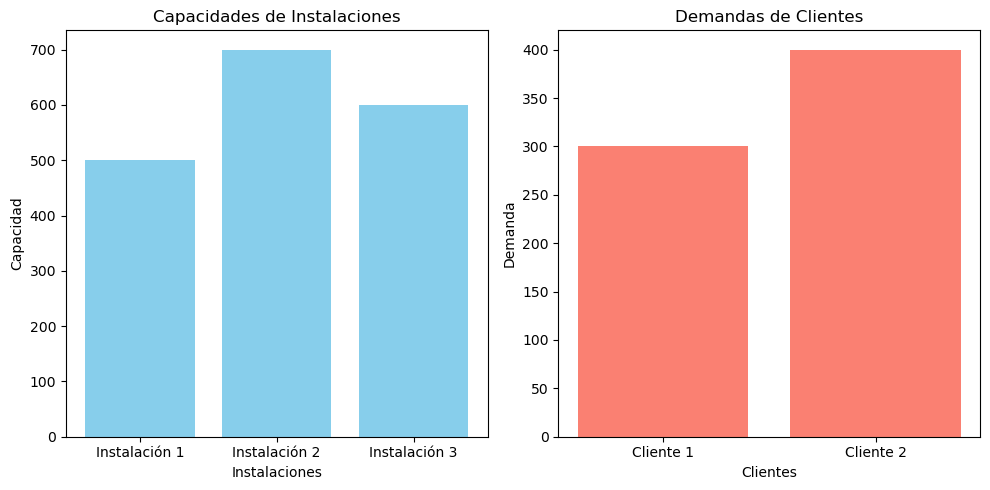

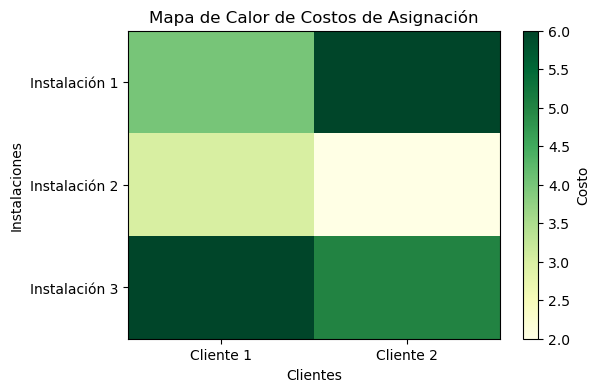

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100, tasa_mutacion=0.05):
    
    poblacion = np.random.randint(2, size=(50, num_instalaciones, num_clientes)) 

    def evaluacion(solucion): 
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)  # Capacidad usada en cada instalación
        demanda_satisfecha = np.zeros(num_clientes)  # Demanda satisfecha por cliente

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:  # No exceder demanda del cliente
                        costo_total += costos_asignacion[instalacion][cliente]
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]
        
        # Verificar capacidades de instalaciones
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:  # Penalizar si la capacidad de una instalación es excedida
                return float('inf')
        
        # Añadir costos de apertura de las instalaciones abiertas
        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]
        
        # Penalización si algún cliente no tiene su demanda completamente satisfecha
        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')
        
        return costo_total

    def seleccion(poblacion):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        # Filtrar solo las soluciones factibles
        factibles = [sol for sol in poblacion if evaluacion(sol) < float('inf')]
        if len(factibles) < 2:
            return np.random.choice(poblacion, size=2)  # Si no hay suficientes factibles, seleccionar al azar
        aptitudes_factibles = [evaluacion(sol) for sol in factibles]
        indices = np.argsort(aptitudes_factibles)[:2]  # Seleccionar las 2 mejores soluciones
        return [factibles[i] for i in indices]  # Usar lista de Python para devolver las soluciones

    def cruce(padre1, padre2):
        punto_cruce = np.random.randint(1, num_clientes)
        hijo = np.zeros_like(padre1)
        for i in range(num_instalaciones):
            hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
            hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
        return hijo

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente] 
        return solucion

    def reemplazo(poblacion, hijo):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        menos_aptos_index = np.argmin(aptitudes)
        poblacion[menos_aptos_index] = hijo

    def repeticion(poblacion):
        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            padres = seleccion(poblacion)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo)
            reemplazo(poblacion, hijo)
            mejor_costo = evaluacion(padres[0])
            print(f"Mejor costo: {mejor_costo}")

            # Mostrar soluciones factibles
            for sol in poblacion:
                costo_sol = evaluacion(sol)
                if costo_sol < float('inf'):
                    print(f"Solución factible: {sol}, Costo: {costo_sol}")

    print("Población inicial:")
    print(poblacion)

    repeticion(poblacion)

    # Representación de datos
    # Datos para las tablas
    instalaciones_df = pd.DataFrame({
        'Instalación': [f'Instalación {i+1}' for i in range(num_instalaciones)],
        'Capacidad': capacidades,
        'Costo de Apertura': costos_apertura
    })

    clientes_df = pd.DataFrame({
        'Cliente': [f'Cliente {i+1}' for i in range(num_clientes)],
        'Demanda': demandas
    })

    costos_asignacion_df = pd.DataFrame(costos_asignacion, columns=[f'Cliente {i+1}' for i in range(num_clientes)], index=[f'Instalación {i+1}' for i in range(num_instalaciones)])

    # Mostrar tablas
    print("\nInstalaciones:")
    print(instalaciones_df)
    print("\nClientes:")
    print(clientes_df)
    print("\nCostos de Asignación:")
    print(costos_asignacion_df)

    # Gráficos
    plt.figure(figsize=(10, 5))

    # Gráfico de Capacidades de Instalaciones
    plt.subplot(1, 2, 1)
    plt.bar(instalaciones_df['Instalación'], instalaciones_df['Capacidad'], color='skyblue')
    plt.title('Capacidades de Instalaciones')
    plt.xlabel('Instalaciones')
    plt.ylabel('Capacidad')

    # Demandas
    plt.subplot(1, 2, 2)
    plt.bar(clientes_df['Cliente'], clientes_df['Demanda'], color='salmon')
    plt.title('Demandas de Clientes')
    plt.xlabel('Clientes')
    plt.ylabel('Demanda')

    plt.tight_layout()
    plt.show()

    # Mapa de Calor de Costos de Asignación
    plt.figure(figsize=(6, 4))
    plt.title('Mapa de Calor de Costos de Asignación')
    plt.imshow(costos_asignacion, cmap='YlGn', aspect='auto')
    plt.colorbar(label='Costo')
    plt.xticks(ticks=np.arange(num_clientes), labels=[f'Cliente {i+1}' for i in range(num_clientes)])
    plt.yticks(ticks=np.arange(num_instalaciones), labels=[f'Instalación {i+1}' for i in range(num_instalaciones)])
    plt.xlabel('Clientes')
    plt.ylabel('Instalaciones')
    plt.show()

# Datos actualizados
num_instalaciones = 3  # Número de instalaciones
num_clientes = 2       # Número de clientes
capacidades = [500, 700, 600]  # Capacidades de las instalaciones
costos_apertura = [1000, 1500, 1200]  # Costos de apertura

# Matriz de costos de asignación corregida a 3x2 (3 instalaciones y 2 clientes)
costos_asignacion = np.array([[4, 6],  # Instalación 1
                              [3, 2],  # Instalación 2
                              [6, 5]]) # Instalación 3

demandas = [300, 400]  # Demandas de los clientes

algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)


Población inicial:
[[[0 1]
  [1 0]
  [1 1]]

 [[0 0]
  [0 0]
  [1 1]]

 [[0 1]
  [1 0]
  [1 1]]

 [[0 1]
  [0 0]
  [0 0]]

 [[1 0]
  [1 0]
  [1 1]]

 [[0 1]
  [1 0]
  [0 0]]

 [[1 1]
  [0 0]
  [0 1]]

 [[0 1]
  [1 0]
  [1 1]]

 [[0 1]
  [1 0]
  [0 1]]

 [[1 0]
  [1 0]
  [1 1]]

 [[1 0]
  [1 0]
  [0 1]]

 [[0 1]
  [0 0]
  [0 1]]

 [[0 0]
  [0 0]
  [1 0]]

 [[1 1]
  [0 1]
  [1 0]]

 [[1 0]
  [0 0]
  [1 1]]

 [[0 1]
  [1 0]
  [1 1]]

 [[1 0]
  [0 0]
  [0 0]]

 [[1 1]
  [1 1]
  [0 0]]

 [[0 0]
  [1 1]
  [0 1]]

 [[0 1]
  [1 0]
  [1 0]]

 [[0 1]
  [1 1]
  [0 0]]

 [[0 1]
  [0 0]
  [1 0]]

 [[0 0]
  [0 1]
  [1 0]]

 [[1 0]
  [1 1]
  [1 0]]

 [[0 0]
  [0 1]
  [0 1]]

 [[0 0]
  [0 0]
  [0 1]]

 [[0 0]
  [0 0]
  [1 0]]

 [[0 1]
  [0 0]
  [1 0]]

 [[1 0]
  [0 1]
  [1 0]]

 [[0 1]
  [0 1]
  [1 0]]

 [[1 1]
  [0 0]
  [1 1]]

 [[1 0]
  [0 1]
  [1 1]]

 [[1 1]
  [0 1]
  [1 0]]

 [[1 1]
  [0 0]
  [0 1]]

 [[0 1]
  [1 0]
  [1 0]]

 [[1 0]
  [1 0]
  [0 1]]

 [[0 0]
  [1 0]
  [1 0]]

 [[0 1]
  [1 1]
  [

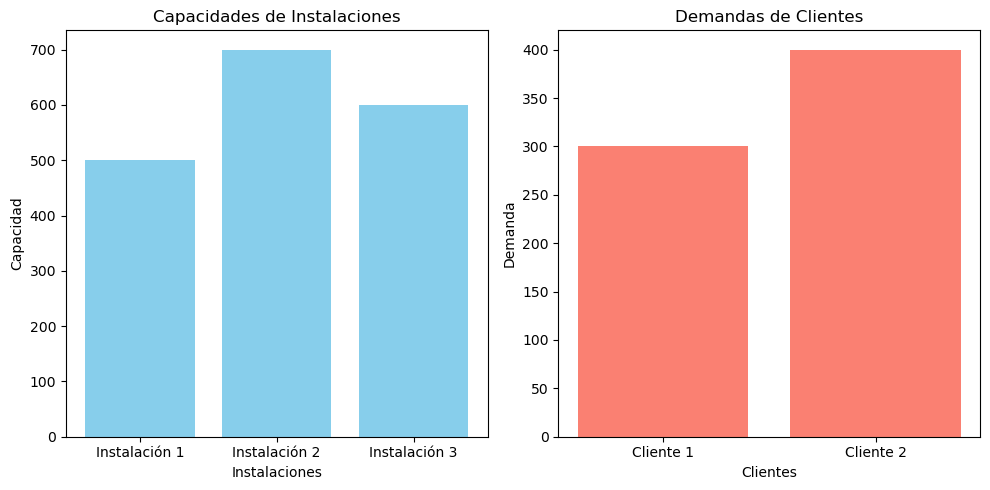

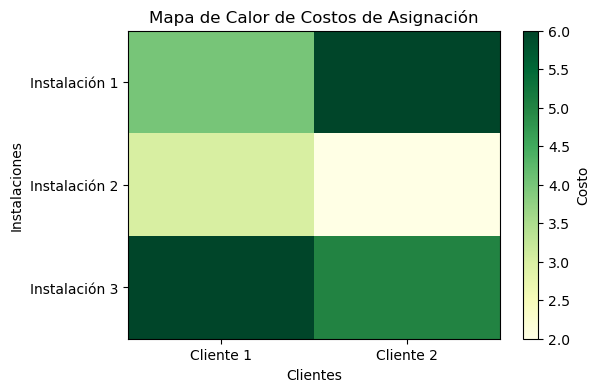

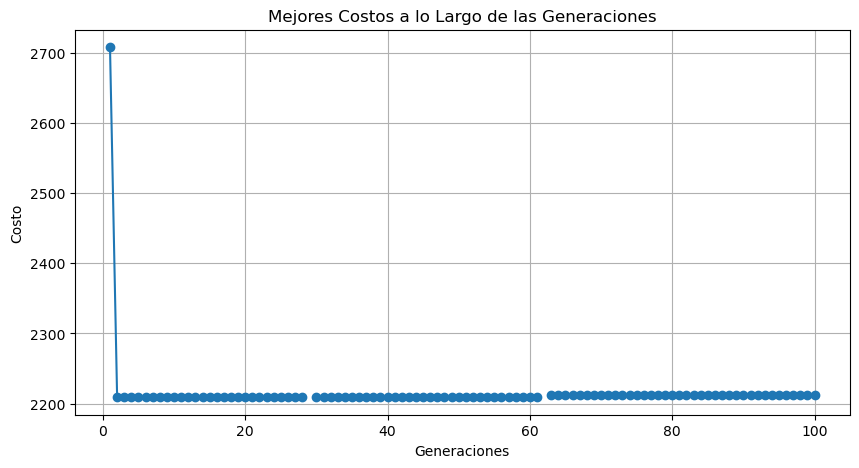

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100, tasa_mutacion=0.05):
    
    poblacion = np.random.randint(2, size=(50, num_instalaciones, num_clientes)) 

    def evaluacion(solucion): 
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)  # Capacidad usada en cada instalación
        demanda_satisfecha = np.zeros(num_clientes)  # Demanda satisfecha por cliente

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:  # No exceder demanda del cliente
                        costo_total += costos_asignacion[instalacion][cliente]
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]
        
        # Verificar capacidades de instalaciones
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:  # Penalizar si la capacidad de una instalación es excedida
                return float('inf')
        
        # Añadir costos de apertura de las instalaciones abiertas
        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]
        
        # Penalización si algún cliente no tiene su demanda completamente satisfecha
        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')
        
        return costo_total

    def seleccion(poblacion):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        # Filtrar solo las soluciones factibles
        factibles = [sol for sol in poblacion if evaluacion(sol) < float('inf')]
        if len(factibles) < 2:
            return np.random.choice(poblacion, size=2)  # Si no hay suficientes factibles, seleccionar al azar
        aptitudes_factibles = [evaluacion(sol) for sol in factibles]
        indices = np.argsort(aptitudes_factibles)[:2]  # Seleccionar las 2 mejores soluciones
        return [factibles[i] for i in indices]  # Usar lista de Python para devolver las soluciones

    def cruce(padre1, padre2):
        punto_cruce = np.random.randint(1, num_clientes)
        hijo = np.zeros_like(padre1)
        for i in range(num_instalaciones):
            hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
            hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
        return hijo

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente] 
        return solucion

    def reemplazo(poblacion, hijo):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        menos_aptos_index = np.argmin(aptitudes)
        poblacion[menos_aptos_index] = hijo

    def repeticion(poblacion):
        mejores_costos = []  # Lista para almacenar los mejores costos de cada generación
        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            padres = seleccion(poblacion)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo)
            reemplazo(poblacion, hijo)
            mejor_costo = evaluacion(padres[0])
            mejores_costos.append(mejor_costo)  # Almacenar el mejor costo de la generación
            print(f"Mejor costo: {mejor_costo}")

            # Mostrar soluciones factibles
            for sol in poblacion:
                costo_sol = evaluacion(sol)
                if costo_sol < float('inf'):
                    print(f"Solución factible: {sol}, Costo: {costo_sol}")

        return mejores_costos  # Devolver la lista de mejores costos

    print("Población inicial:")
    print(poblacion)

    mejores_costos = repeticion(poblacion)  # Llamar a la función y almacenar los costos

    # Representación de datos
    # Datos para las tablas
    instalaciones_df = pd.DataFrame({
        'Instalación': [f'Instalación {i+1}' for i in range(num_instalaciones)],
        'Capacidad': capacidades,
        'Costo de Apertura': costos_apertura
    })

    clientes_df = pd.DataFrame({
        'Cliente': [f'Cliente {i+1}' for i in range(num_clientes)],
        'Demanda': demandas
    })

    costos_asignacion_df = pd.DataFrame(costos_asignacion, columns=[f'Cliente {i+1}' for i in range(num_clientes)], index=[f'Instalación {i+1}' for i in range(num_instalaciones)])

    # Mostrar tablas
    print("\nInstalaciones:")
    print(instalaciones_df)
    print("\nClientes:")
    print(clientes_df)
    print("\nCostos de Asignación:")
    print(costos_asignacion_df)

    # Gráficos
    plt.figure(figsize=(10, 5))

    # Gráfico de Capacidades de Instalaciones
    plt.subplot(1, 2, 1)
    plt.bar(instalaciones_df['Instalación'], instalaciones_df['Capacidad'], color='skyblue')
    plt.title('Capacidades de Instalaciones')
    plt.xlabel('Instalaciones')
    plt.ylabel('Capacidad')

    # Demandas
    plt.subplot(1, 2, 2)
    plt.bar(clientes_df['Cliente'], clientes_df['Demanda'], color='salmon')
    plt.title('Demandas de Clientes')
    plt.xlabel('Clientes')
    plt.ylabel('Demanda')

    plt.tight_layout()
    plt.show()

    # Mapa de Calor de Costos de Asignación
    plt.figure(figsize=(6, 4))
    plt.title('Mapa de Calor de Costos de Asignación')
    plt.imshow(costos_asignacion, cmap='YlGn', aspect='auto')
    plt.colorbar(label='Costo')
    plt.xticks(ticks=np.arange(num_clientes), labels=[f'Cliente {i+1}' for i in range(num_clientes)])
    plt.yticks(ticks=np.arange(num_instalaciones), labels=[f'Instalación {i+1}' for i in range(num_instalaciones)])
    plt.xlabel('Clientes')
    plt.ylabel('Instalaciones')
    plt.show()

    # Gráfico de líneas de mejores costos a lo largo de las generaciones
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, generaciones + 1), mejores_costos, marker='o')
    plt.title('Mejores Costos a lo Largo de las Generaciones')
    plt.xlabel('Generaciones')
    plt.ylabel('Costo')
    plt.grid(True)
    plt.show()

# Datos actualizados
num_instalaciones = 3  # Número de instalaciones
num_clientes = 2       # Número de clientes
capacidades = [500, 700, 600]  # Capacidades de las instalaciones
costos_apertura = [1000, 1500, 1200]  # Costos de apertura

# Matriz de costos de asignación corregida a 3x2 (3 instalaciones y 2 clientes)
costos_asignacion = np.array([[4, 6],  # Instalación 1
                              [3, 2],  # Instalación 2
                              [6, 5]]) # Instalación 3

demandas = [300, 400]  # Demandas de los clientes

algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100, tasa_mutacion=0.2):
    
    poblacion = np.random.randint(2, size=(500, num_instalaciones, num_clientes)) 

    def evaluacion(solucion): 
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)  
        demanda_satisfecha = np.zeros(num_clientes)  

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:  
                        costo_total += costos_asignacion[instalacion][cliente]
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]
        
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:  
                return float('inf')
        
        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]
        
        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')
        
        return costo_total

    def seleccion(poblacion):
        factibles = [sol for sol in poblacion if evaluacion(sol) < float('inf')]
        if len(factibles) < 2:
            return np.random.choice(poblacion, size=2)  
        aptitudes_factibles = [evaluacion(sol) for sol in factibles]
        indices = np.argsort(aptitudes_factibles)[:2]  
        return [factibles[i] for i in indices]  

    def cruce(padre1, padre2):
        punto_cruce = np.random.randint(1, num_clientes)
        hijo = np.zeros_like(padre1)
        for i in range(num_instalaciones):
            hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
            hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
        return hijo

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente] 
        return solucion

    def reemplazo(poblacion, hijo):
        aptitudes = [evaluacion(solucion) for solucion in poblacion]
        menos_aptos_index = np.argmin(aptitudes)
        poblacion[menos_aptos_index] = hijo

    def repeticion(poblacion):
        mejores_costos = []  
        costos_validos = []  # Para almacenar soluciones válidas y sus costos
        
        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            padres = seleccion(poblacion)
            hijo = cruce(padres[0], padres[1])
            hijo = mutacion(hijo)
            reemplazo(poblacion, hijo)
            mejor_costo = evaluacion(padres[0])
            mejores_costos.append(mejor_costo)  
            
            for sol in poblacion:
                costo_sol = evaluacion(sol)
                if costo_sol < float('inf'):
                    costos_validos.append((sol, costo_sol))
                    print(f"Solución válida: {sol}, Costo: {costo_sol}")  

        return mejores_costos, costos_validos  # Devuelve los mejores costos y las soluciones válidas

    print("Población inicial:")
    print(poblacion)

    mejores_costos, costos_validos = repeticion(poblacion)  

    # Mostrar tabla de costos válidos
    print("\nCostos válidos encontrados durante la ejecución:")
    for sol, costo in costos_validos:
        print(f"Solución: {sol}, Costo: {costo}")

# Datos actualizados
num_instalaciones = 3  
num_clientes = 2       
capacidades = [500, 700, 600]  
costos_apertura = [1000, 1500, 1200]  

costos_asignacion = np.array([[4, 6],  
                              [3, 2],  
                              [6, 5]]) 

demandas = [300, 400]  

algoritmo_genetico(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)



Población inicial:
[[[0 1]
  [1 1]
  [1 1]]

 [[0 1]
  [1 1]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]

 ...

 [[0 1]
  [1 1]
  [1 0]]

 [[1 1]
  [0 0]
  [0 0]]

 [[1 1]
  [0 0]
  [1 0]]]
Generación 1:
Solución válida: [[0 1]
 [1 1]
 [1 1]], Costo: 2509
Solución válida: [[0 1]
 [1 1]
 [1 0]], Costo: 2509
Solución válida: [[0 1]
 [1 1]
 [1 0]], Costo: 2509
Solución válida: [[0 1]
 [1 0]
 [1 1]], Costo: 2509
Solución válida: [[1 0]
 [1 1]
 [1 1]], Costo: 2506
Solución válida: [[1 0]
 [1 1]
 [1 1]], Costo: 2506
Solución válida: [[0 1]
 [0 0]
 [1 0]], Costo: 2212
Solución válida: [[0 1]
 [1 1]
 [0 0]], Costo: 2509
Solución válida: [[1 0]
 [1 0]
 [1 1]], Costo: 2209
Solución válida: [[0 1]
 [1 0]
 [0 0]], Costo: 2509
Solución válida: [[1 0]
 [1 0]
 [0 1]], Costo: 2209
Solución válida: [[0 1]
 [1 1]
 [1 1]], Costo: 2509
Solución válida: [[1 0]
 [1 0]
 [1 1]], Costo: 2209
Solución válida: [[0 1]
 [0 0]
 [1 0]], Costo: 2212
Solución válida: [[0 1]
 [1 1]
 [0 0]], Costo: 2509
Solución válida: [[1 0]
 

Población inicial:
[[[1 1]
  [0 0]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]

 [[1 1]
  [1 1]
  [1 1]]

 ...

 [[1 1]
  [1 1]
  [1 1]]

 [[0 1]
  [1 0]
  [0 0]]

 [[0 1]
  [1 1]
  [1 0]]]
Generación 1:
Solución válida: [[0 1]
 [1 1]
 [1 1]], Costo: 2509
Solución válida: [[0 1]
 [0 0]
 [1 0]], Costo: 2212
Solución válida: [[0 1]
 [1 1]
 [1 1]], Costo: 2509
Solución válida: [[0 1]
 [0 1]
 [1 1]], Costo: 2212
Solución válida: [[0 1]
 [1 0]
 [0 1]], Costo: 2509
Solución válida: [[0 0]
 [1 0]
 [1 1]], Costo: 2708
Solución válida: [[1 0]
 [1 1]
 [0 1]], Costo: 2506
Solución válida: [[0 0]
 [0 1]
 [1 1]], Costo: 2708
Solución válida: [[0 1]
 [0 0]
 [1 1]], Costo: 2212
Solución válida: [[0 0]
 [1 1]
 [1 0]], Costo: 1505
Solución válida: [[0 0]
 [1 1]
 [1 0]], Costo: 1505
Solución válida: [[0 0]
 [1 1]
 [0 1]], Costo: 1505
Solución válida: [[1 0]
 [0 1]
 [1 1]], Costo: 2506
Solución válida: [[1 0]
 [0 1]
 [1 0]], Costo: 2506
Solución válida: [[0 0]
 [1 0]
 [0 1]], Costo: 2708
Solución válida: [[1 0]
 

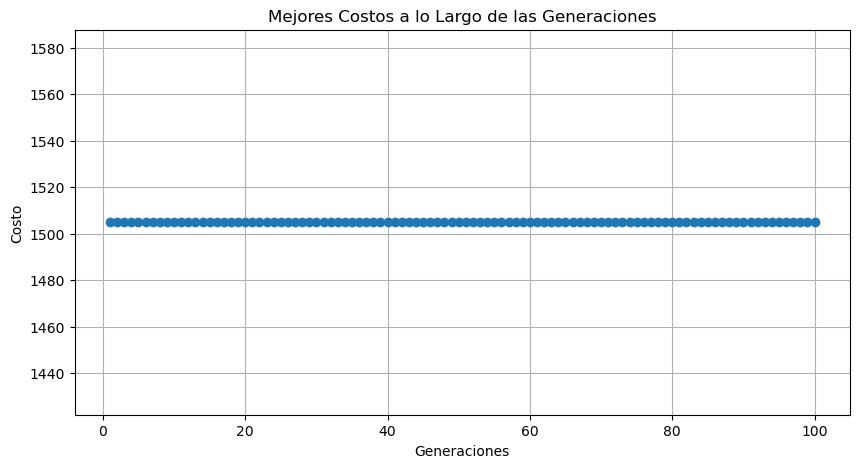


Mejor solución factible encontrada: [[0 0]
 [1 1]
 [1 0]], Costo: 1505


In [102]:
import numpy as np
import matplotlib.pyplot as plt

def algoritmo_genetico_cflp(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100):
    # Parámetros del algoritmo
    tamaño_poblacion = 500
    tasa_seleccion = 0.7
    tasa_cruce = 0.9
    tasa_mutacion = 0.2

    # Inicializar población
    poblacion = np.random.randint(2, size=(tamaño_poblacion, num_instalaciones, num_clientes))

    def evaluacion(solucion):
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)
        demanda_satisfecha = np.zeros(num_clientes)

        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    if demanda_satisfecha[cliente] < demandas[cliente]:
                        capacidad_usada[instalacion] += demandas[cliente]
                        demanda_satisfecha[cliente] += demandas[cliente]
                        costo_total += costos_asignacion[instalacion][cliente]

        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:
                return float('inf')

        for i in range(num_instalaciones):
            if capacidad_usada[i] > 0:
                costo_total += costos_apertura[i]

        for cliente in range(num_clientes):
            if demanda_satisfecha[cliente] < demandas[cliente]:
                return float('inf')

        return costo_total

    def seleccion_torneo(poblacion):
        torneo_size = 3  # Tamaño del torneo
        indices = np.random.choice(range(len(poblacion)), size=torneo_size, replace=False)
        aptitudes_torneo = [evaluacion(poblacion[i]) for i in indices]
        mejor_indice = indices[np.argmin(aptitudes_torneo)]
        return poblacion[mejor_indice]

    def cruce(padre1, padre2):
        if np.random.random() < tasa_cruce:  # Aplicar cruce según la tasa de cruce
            punto_cruce = np.random.randint(1, num_clientes)
            hijo = np.zeros_like(padre1)
            for i in range(num_instalaciones):
                hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
                hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
            return hijo
        return padre1.copy()  # Sin cruce

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente]
        return solucion

    def repeticion(poblacion):
        mejores_costos = []
        mejor_solucion_factible = None
        mejor_costo_factible = float('inf')

        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            nueva_poblacion = []

            while len(nueva_poblacion) < tamaño_poblacion:
                padre1 = seleccion_torneo(poblacion)
                padre2 = seleccion_torneo(poblacion)
                hijo = cruce(padre1, padre2)
                hijo = mutacion(hijo)
                nueva_poblacion.append(hijo)

            poblacion = np.array(nueva_poblacion)

            # Evaluar la mejor solución
            for sol in poblacion:
                costo_sol = evaluacion(sol)
                if costo_sol < mejor_costo_factible and costo_sol < float('inf'):
                    mejor_costo_factible = costo_sol
                    mejor_solucion_factible = sol

                if costo_sol < float('inf'):
                    print(f"Solución válida: {sol}, Costo: {costo_sol}")

            mejores_costos.append(mejor_costo_factible)

        return mejores_costos, mejor_solucion_factible, mejor_costo_factible

    print("Población inicial:")
    print(poblacion)

    mejores_costos, mejor_solucion, mejor_costo = repeticion(poblacion)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, generaciones + 1), mejores_costos, marker='o')
    plt.title('Mejores Costos a lo Largo de las Generaciones')
    plt.xlabel('Generaciones')
    plt.ylabel('Costo')
    plt.grid(True)
    plt.show()

    if mejor_solucion is not None:
        print(f"\nMejor solución factible encontrada: {mejor_solucion}, Costo: {mejor_costo}")

# Datos de ejemplo
num_instalaciones = 3
num_clientes = 2
capacidades = [500, 700, 600]
costos_apertura = [1000, 1500, 1200]
costos_asignacion = np.array([[4, 6], [3, 2], [6, 5]])
demandas = [300, 400]

algoritmo_genetico_cflp(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)


Población inicial:
[[[1 1]
  [1 1]
  [0 1]]

 [[1 0]
  [0 1]
  [1 0]]

 [[0 1]
  [0 0]
  [0 0]]

 ...

 [[0 1]
  [1 0]
  [1 1]]

 [[0 1]
  [1 0]
  [1 1]]

 [[0 0]
  [0 1]
  [1 1]]]
Generación 1:
Generación 2:
Generación 3:
Generación 4:
Generación 5:
Generación 6:
Generación 7:
Generación 8:
Generación 9:
Generación 10:
Generación 11:
Generación 12:
Generación 13:
Generación 14:
Generación 15:
Generación 16:
Generación 17:
Generación 18:
Generación 19:
Generación 20:
Generación 21:
Generación 22:
Generación 23:
Generación 24:
Generación 25:
Generación 26:
Generación 27:
Generación 28:
Generación 29:
Generación 30:
Generación 31:
Generación 32:
Generación 33:
Generación 34:
Generación 35:
Generación 36:
Generación 37:
Generación 38:
Generación 39:
Generación 40:
Generación 41:
Generación 42:
Generación 43:
Generación 44:
Generación 45:
Generación 46:
Generación 47:
Generación 48:
Generación 49:
Generación 50:
Generación 51:
Generación 52:
Generación 53:
Generación 54:
Generación 55:
Gen

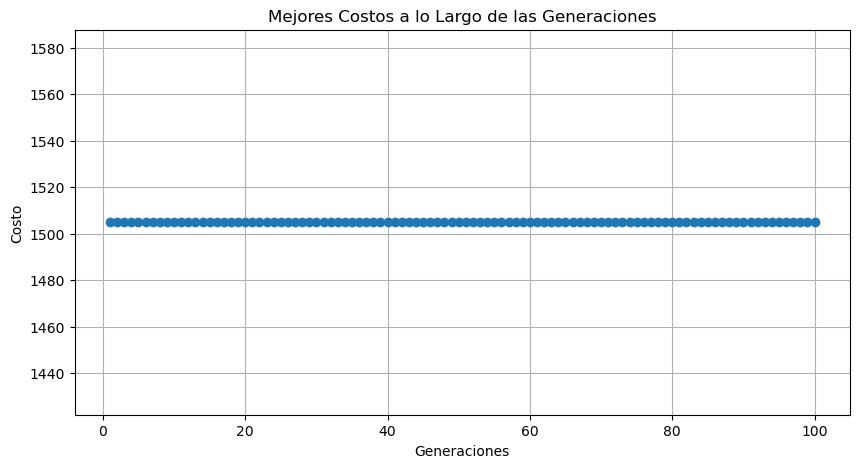


Mejor solución factible encontrada: [[0 0]
 [1 1]
 [0 0]], Costo: 1505


In [104]:
import numpy as np
import matplotlib.pyplot as plt

def algoritmo_genetico_cflp(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100):
    tamaño_poblacion = 500
    tasa_seleccion = 0.7
    tasa_cruce = 0.9
    tasa_mutacion = 0.2

    # Inicializar población
    poblacion = np.random.randint(2, size=(tamaño_poblacion, num_instalaciones, num_clientes))

    def evaluacion(solucion):
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)
        demanda_satisfecha = np.zeros(num_clientes)

        # Calcular costos y capacidades
        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    capacidad_usada[instalacion] += demandas[cliente]
                    costo_total += costos_asignacion[instalacion][cliente]

        # Verificar capacidades
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:
                return float('inf')  # Infeasible if capacity is exceeded

        # Calcular costo de apertura
        for i in range(num_instalaciones):
            if np.any(solucion[i] == 1):  # Si la instalación está abierta
                costo_total += costos_apertura[i]

        # Verificar si se satisfacen todas las demandas
        for cliente in range(num_clientes):
            if not any(solucion[i][cliente] == 1 for i in range(num_instalaciones)):
                return float('inf')  # Infeasible if demand is not satisfied

        return costo_total

    def seleccion_torneo(poblacion):
        torneo_size = 3
        indices = np.random.choice(range(len(poblacion)), size=torneo_size, replace=False)
        aptitudes_torneo = [evaluacion(poblacion[i]) for i in indices]
        mejor_indice = indices[np.argmin(aptitudes_torneo)]
        return poblacion[mejor_indice]

    def cruce(padre1, padre2):
        if np.random.random() < tasa_cruce:
            punto_cruce = np.random.randint(1, num_clientes)
            hijo = np.zeros_like(padre1)
            for i in range(num_instalaciones):
                hijo[i][:punto_cruce] = padre1[i][:punto_cruce]
                hijo[i][punto_cruce:] = padre2[i][punto_cruce:]
            return hijo
        return padre1.copy()

    def mutacion(solucion):
        for i in range(num_instalaciones):
            if np.random.random() < tasa_mutacion:
                cliente = np.random.randint(num_clientes)
                solucion[i][cliente] = 1 - solucion[i][cliente]
        return solucion

    def repeticion(poblacion):
        mejores_costos = []
        mejor_solucion_factible = None
        mejor_costo_factible = float('inf')

        for generacion in range(generaciones):
            print(f"Generación {generacion + 1}:")
            nueva_poblacion = []

            while len(nueva_poblacion) < tamaño_poblacion:
                padre1 = seleccion_torneo(poblacion)
                padre2 = seleccion_torneo(poblacion)
                hijo = cruce(padre1, padre2)
                hijo = mutacion(hijo)

                # Solo añadir soluciones válidas a la nueva población
                if evaluacion(hijo) < float('inf'):
                    nueva_poblacion.append(hijo)

            # Si no se generaron suficientes soluciones válidas, rellenar con soluciones aleatorias
            while len(nueva_poblacion) < tamaño_poblacion:
                nueva_solucion = np.random.randint(2, size=(num_instalaciones, num_clientes))
                if evaluacion(nueva_solucion) < float('inf'):
                    nueva_poblacion.append(nueva_solucion)

            poblacion = np.array(nueva_poblacion)

            # Evaluar la mejor solución
            for sol in poblacion:
                costo_sol = evaluacion(sol)
                if costo_sol < mejor_costo_factible and costo_sol < float('inf'):
                    mejor_costo_factible = costo_sol
                    mejor_solucion_factible = sol

            mejores_costos.append(mejor_costo_factible)

        return mejores_costos, mejor_solucion_factible, mejor_costo_factible

    print("Población inicial:")
    print(poblacion)

    mejores_costos, mejor_solucion, mejor_costo = repeticion(poblacion)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, generaciones + 1), mejores_costos, marker='o')
    plt.title('Mejores Costos a lo Largo de las Generaciones')
    plt.xlabel('Generaciones')
    plt.ylabel('Costo')
    plt.grid(True)
    plt.show()

    if mejor_solucion is not None:
        print(f"\nMejor solución factible encontrada: {mejor_solucion}, Costo: {mejor_costo}")

# Datos de ejemplo
num_instalaciones = 3
num_clientes = 2
capacidades = [500, 700, 600]
costos_apertura = [1000, 1500, 1200]
costos_asignacion = np.array([[4, 6], [3, 2], [6, 5]])
demandas = [300, 400]

algoritmo_genetico_cflp(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def algoritmo_genetico_cflp(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas, generaciones=100):
    tamaño_poblacion = 500
    tasa_seleccion = 0.7
    tasa_cruce = 0.9
    tasa_mutacion = 0.2

    # Inicializar población
    poblacion = np.random.randint(2, size=(tamaño_poblacion, num_instalaciones, num_clientes))

    def evaluacion(solucion):
        costo_total = 0
        capacidad_usada = np.zeros(num_instalaciones)
        demanda_satisfecha = np.zeros(num_clientes)

        # Calcular costos y capacidades
        for cliente in range(num_clientes):
            for instalacion in range(num_instalaciones):
                if solucion[instalacion][cliente] == 1:
                    capacidad_usada[instalacion] += demandas[cliente]
                    costo_total += costos_asignacion[instalacion][cliente]

        # Verificar capacidades
        for i in range(num_instalaciones):
            if capacidad_usada[i] > capacidades[i]:
                return float('inf')  # Infeasible if capacity is exceeded

        # Calcular costo de apertura
        for i in range(num_instalaciones):
            if np.any(solucion[i] == 1):  # Si la instalación está abierta
                costo_total += costos_apertura[i]

        # Verificar si se satisfacen todas las demandas
        for cliente in range(num_clientes):
            if not any(solucion[i][cliente] == 1 for i in range(num_instalaciones)):
                return float('inf')  # Infeasible if demand is not satisfied

        return 

    def seleccion(poblacion):
        
        return 

    def cruce(padre1, padre2):
        
        return 

    def mutacion(solucion):
       
        return 

    def repeticion(poblacion):
      

        return 


    if mejor_solucion is not None:
        print(f"\nMejor solución factible encontrada: {mejor_solucion}, Costo: {mejor_costo}")

# Datos de ejemplo
num_instalaciones = 3
num_clientes = 2
capacidades = [500, 700, 600]
costos_apertura = [1000, 1500, 1200]
costos_asignacion = np.array([[4, 6], [3, 2], [6, 5]])
demandas = [300, 400]

algoritmo_genetico_cflp(num_instalaciones, num_clientes, capacidades, costos_apertura, costos_asignacion, demandas)